### Disclaimer

Dieses Notebook ist im Rahmen  meiner Bachelorarbeit mit dem Titel **"Learning Using Statistical Invariants"** entstanden.

Zugehörig sind zwei .py Datei, in denen der Haupteil der Implemetierung zu finden ist. Das Notebook dient hauptsächlich der Visualisierung.
Kommentare im Code sind auf Englisch.

In der Datei lusi_AndreasLoehr.py finden sich 2 Klassen, in denen das Training im LUSI bzw. ERM-LUSI Framework realisiert ist.
Die Problemstellung, die bearbeitet wurde, ist ein binäres Klassifikationsproblem für zwei Ziffern aus dem MNIST Datensatz. Konkret handelt es sich um die binäre Klassifikation der Ziffern 7 und 8.

Weiter sind zahlreiche Hilfsfunktionen bereitgestellt. Es ist nicht auszuschließen, dass an der ein oder anderen Stelle kleine Änderungen gemacht werden müssen, sollte man ein Problem von anderer Natur behandeln wollen. Insbesondere die bereitgestellten Prädikate sind nur für das MNIST Problem geeignet.



In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import lusi_periphery
import lusi_Andreas_Loehr as lal
import pandas as pd
from pprint import pprint

2022-05-22 16:23:34.686799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading/ Importing Data

In [4]:
# load MNIST here
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
# extract 7 and 8 for binary classification problem
# scale pixel values to take values in [0,1] interval
eights = x_train[y_train == 8]/255
sevens = x_train[y_train == 7]/255
y_eights = np.ones(eights.shape[0])
y_sevens = np.zeros(sevens.shape[0])
x_train = np.concatenate([eights, sevens])
y_train = np.concatenate([y_eights, y_sevens])

# same for test data
eights_test = x_test[y_test == 8]/255
sevens_test = x_test[y_test == 7]/255
y_eights_test = np.ones(eights_test.shape[0])
y_sevens_test = np.zeros(sevens_test.shape[0])
x_test = np.concatenate([eights_test, sevens_test])
y_test = np.concatenate([y_eights_test, y_sevens_test])

In [7]:
# wrapping data in custom class Periphery
full_data = lusi_periphery.Periphery((x_train, y_train), (x_test, y_test), lal.phi_11)

# Visualizing Data

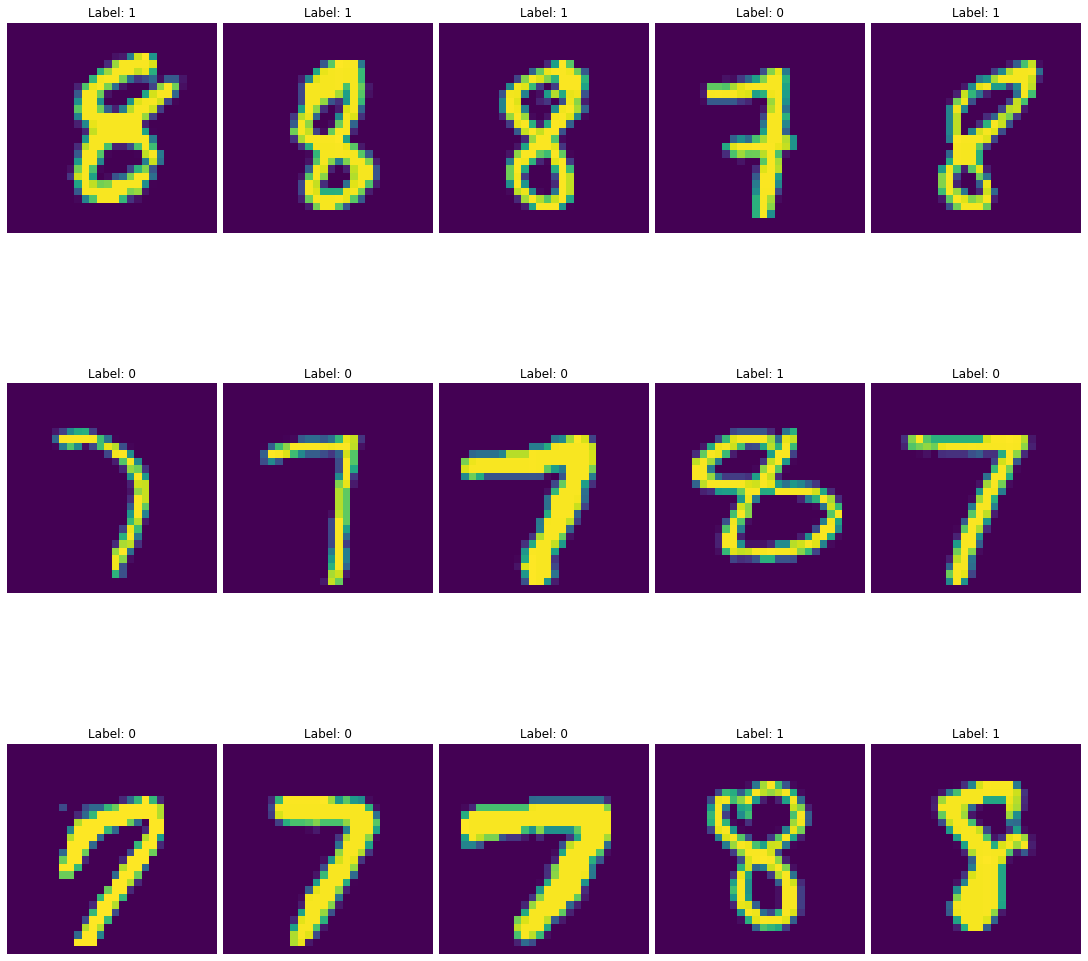

In [112]:
lusi_periphery.visual_validation(15,
    (full_data.train_data_x, full_data.train_data_y))


# Predicates' empirical distribution on train data

In diesem Abschnitt soll untersucht werden, wie dien bedingte empirische Verteilung der Prädikate basierend auf den Traininsdaten bedingt auf eine der Klassen (7 oder 8) aussieht. Zur Illustration betrachten wir ein Histogramm.

In [99]:
preds_visualize_names = ["Average Pixel Intensity",
                         "Vertical Symmetry",
                         "Horizontal Symmetry",
                         "Diagonal Symmetry", 
                         "Holes",
                         "Weighted Pixel Intesity",
                         "Center Pixel Intensity",
                         "Lower Left Pixel Intensity",
                         "Upper Right Pixel Intensity",
                         "Upper Left Pixel =Intensity",
                         "Lower Left Pixel Intensity"]

subplot_labels = [("Intensity", "# of Samples"),
                  ("Symmetrie Score", "# of Samples"),
                  ("Symmetrie Score", "# of Samples"),
                  ("Symmetrie Score", "# of Samples"),
                  ("# of Holes", "# of Samples"),
                  ("Intensity", "# of Samples"),
                  ("Intensity", "# of Samples"),
                  ("Intensity", "# of Samples"),
                  ("Intensity", "# of Samples"),
                  ("Intensity", "# of Samples"),
                  ("Intensity", "# of Samples")]


In [86]:
# obtain evaluations on data for these functions
preds_visualize = full_data.phi_eval_train[:, :]

In [87]:
preds_on_8 = preds_visualize[full_data.train_data_y==1]
preds_on_7 = preds_visualize[full_data.train_data_y==0]

In [103]:
print(f"Number of samples for digit 7 {preds_on_7.shape[0]}")
print(f"Number of samples for digit 8 {preds_on_8.shape[0]}")

Number of samples for digit 7 6265
Number of samples for digit 8 5851


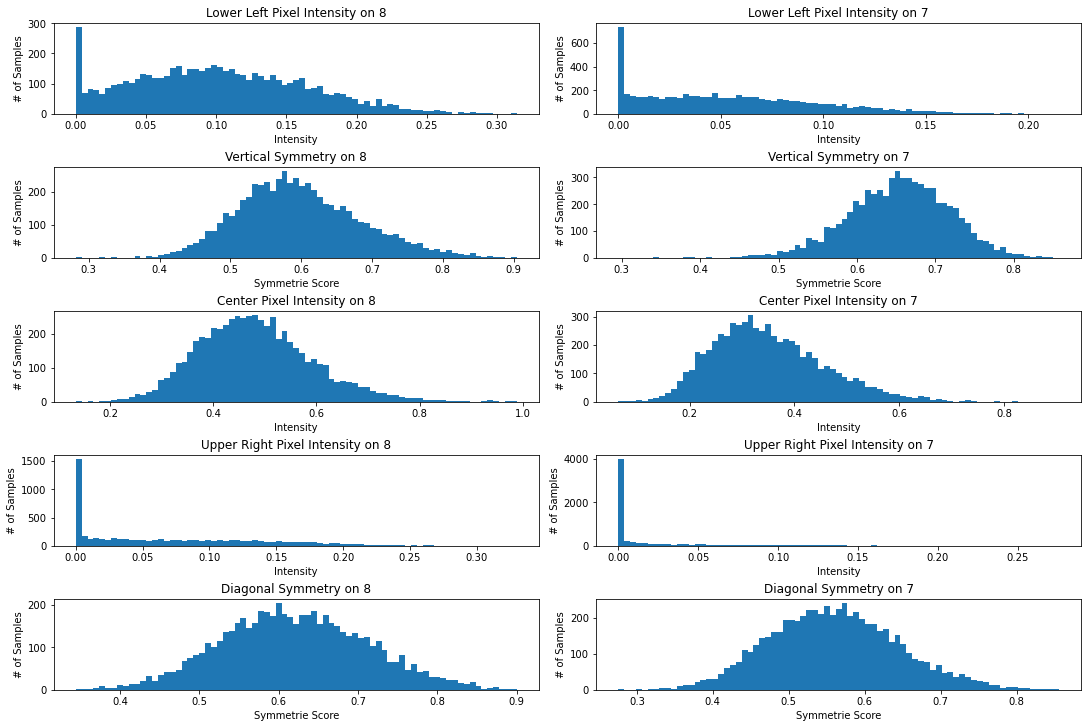

In [104]:
# randomly select 10 predicates and display
fig, ax = plt.subplots(nrows=5, ncols=2,
                       figsize=(15,10), constrained_layout=True)

# populate grid with images + labels
for i in range(5):
    j = np.random.randint(0, 11 ,1)[0]
    ax[i, 0].hist(preds_on_8[:, j].numpy(), bins=75)
    ax[i, 0].set_xlabel(f"{subplot_labels[j][0]}")
    ax[i, 0].set_ylabel(f"{subplot_labels[j][1]}")
    ax[i, 0].set_title(f"{preds_visualize_names[j]} on 8")
    ax[i, 1].hist(preds_on_7[:, j].numpy(), bins=75)
    ax[i, 1].set_title(f"{preds_visualize_names[j]} on 7")
    ax[i, 1].set_xlabel(f"{subplot_labels[j][0]}")
    ax[i, 1].set_ylabel(f"{subplot_labels[j][1]}")

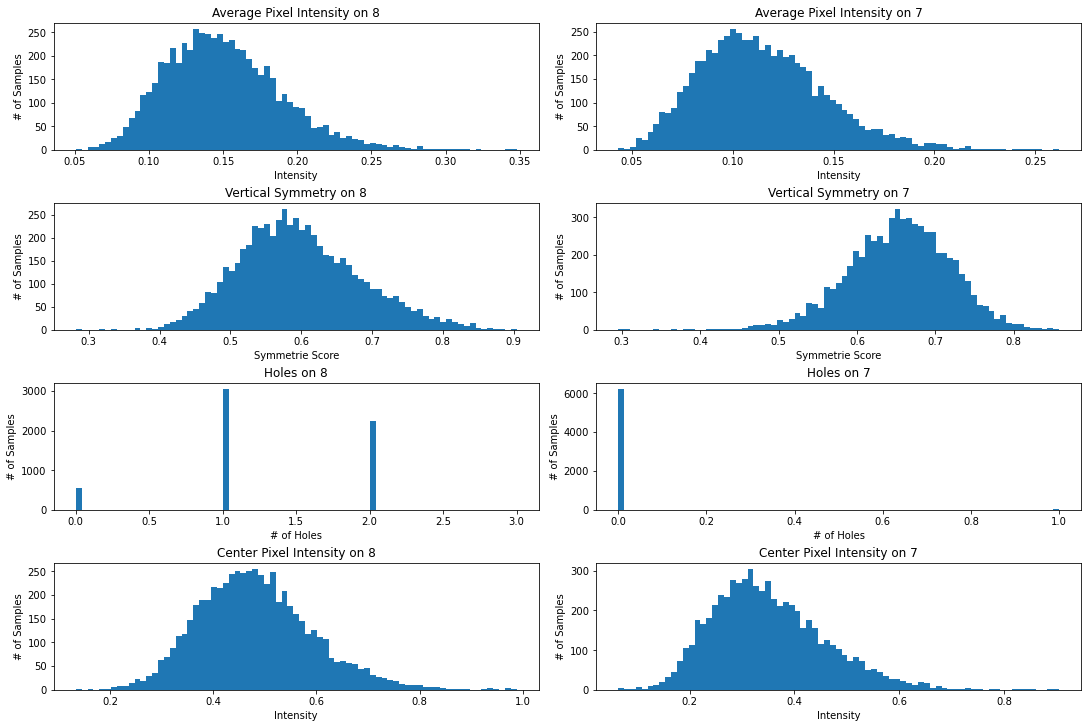

In [105]:
# visualizations for export
ilus_pred = [0, 1, 4, 6]
fig, ax = plt.subplots(nrows=4, ncols=2,
                       figsize=(15,10), constrained_layout=True)
# fig.tight_layout()
# populate grid with images + labels
for i in range(4):
    j = ilus_pred[i]
    ax[i, 0].hist(preds_on_8[:, j].numpy(), bins=75)
    ax[i, 0].set_xlabel(f"{subplot_labels[j][0]}")
    ax[i, 0].set_ylabel(f"{subplot_labels[j][1]}")
    ax[i, 0].set_title(f"{preds_visualize_names[j]} on 8")
    ax[i, 1].hist(preds_on_7[:, j].numpy(), bins=75)
    ax[i, 1].set_title(f"{preds_visualize_names[j]} on 7")
    ax[i, 1].set_xlabel(f"{subplot_labels[j][0]}")
    ax[i, 1].set_ylabel(f"{subplot_labels[j][1]}")

plt.savefig("./predicates.jpg")

# Training a LUSI Model

The following cells contain a demonstration of the usage of the _LusiModel_ class.

The complete dataset is used for the purpose of this demonstration

In [136]:
print(f"Training data shape: {(full_data.train_data_x.shape, full_data.train_data_y.shape)}")
print(f"Training data predicate evaluations shape: {full_data.phi_eval_train.shape}")

# Generating batch datasets for training (and testing which won't be used in this implementation)
train_batch, test_batch = full_data.generate_batch_data(64,64)

# defining the weight matrix 'W' from paper. We need to know # of predicates for this step
# for now, use identity matrix
w_matrix = tf.Variable(np.diag(np.ones(full_data.phi_eval_train.shape[1])), dtype=tf.float32)


underlying_model = keras.Sequential(
    [
     layers.Flatten(input_shape=(28,28)),
     layers.Dense(500, activation="relu", name="hidden_layer_1"),
     layers.Dense(200, activation="relu", name="hidden_layer_2"),
     layers.Dense(50, activation="relu", name="hidden_layer_3"), 
     # interpret output as prob. for class 1
     layers.Dense(1, activation="sigmoid", name="output_layer")
    ])
underlying_model.summary()

Training data shape: ((12116, 28, 28), (12116,))
Training data predicate evaluations shape: (12116, 11)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 500)               392500    
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               100200    
                                                                 
 hidden_layer_3 (Dense)      (None, 50)                10050     
                                                                 
 output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 502,801
Trainable params: 502,801
Non-trainable params: 0
__________

In [137]:
# Define eval metrics
eval_metrics = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Precision(),
    keras.metrics.Recall(),
    keras.metrics.FalsePositives(),
    keras.metrics.FalseNegatives()]

In [138]:
# Instantiation of model
lusi_model = lal.LusiModel(w_matrix, model=underlying_model)

# Add optimizer
lusi_model.add_optimizer(tf.keras.optimizers.SGD())

# Evaluate model on test data before training to see untrained performance
lusi_model.evaluate(full_data.test_data, eval_metrics)

[('binary_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.47502497>),
 ('precision_1', <tf.Tensor: shape=(), dtype=float32, numpy=0.47583178>),
 ('recall_1', <tf.Tensor: shape=(), dtype=float32, numpy=0.77823406>),
 ('false_positives_1', <tf.Tensor: shape=(), dtype=float32, numpy=835.0>),
 ('false_negatives_1', <tf.Tensor: shape=(), dtype=float32, numpy=216.0>)]

In [141]:
# Train model on training data and evaluate afterwards on test data
lusi_model.train(train_batch, epochs=5)
lusi_model.evaluate(full_data.test_data, eval_metrics)


Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4


[('binary_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.96503496>),
 ('precision_1', <tf.Tensor: shape=(), dtype=float32, numpy=0.9679089>),
 ('recall_1', <tf.Tensor: shape=(), dtype=float32, numpy=0.9599589>),
 ('false_positives_1', <tf.Tensor: shape=(), dtype=float32, numpy=31.0>),
 ('false_negatives_1', <tf.Tensor: shape=(), dtype=float32, numpy=39.0>)]

### Short Summary:
Training a model in the LUSI framework is easy. The demonstration above consists of the following steps:
1. Preparing the data with the Periphery class and generating batched data.
2. Depending on the number of predicates, create a matrix of the appropriate dimensions.
3. Specify a model architecture in with the keras.Sequential API.
4. Define some evaluation metrics.
5. Instantiate LusiModel object with model architecture and matrix.
6. Call the train method on the batched data, specifying the number of epochs to train.


# Training an ERM-LUSI Model

The following cells contain a demonstration of the usage of the _LusiErm_ class.

The complete dataset is used for the purpose of this demonstration. Essentially, we are following the steps of the demonstration for the _LusiModel_ class

In [143]:
# These steps remain unchanged - same as with LusiModel class

print(f"Training data shape: {(full_data.train_data_x.shape, full_data.train_data_y.shape)}")
print(f"Training data predicate evaluations shape: {full_data.phi_eval_train.shape}")

# Generating batch datasets for training (and testing which won't be used in this implementation)
train_batch, test_batch = full_data.generate_batch_data(64,64)

# defining the weight matrix 'W' from paper. We need to know # of predicates for this step
# for now, use identity matrix
w_matrix = tf.Variable(np.diag(np.ones(full_data.phi_eval_train.shape[1])), dtype=tf.float32)


underlying_model = keras.Sequential(
    [
     layers.Flatten(input_shape=(28,28)),
     layers.Dense(500, activation="relu", name="hidden_layer_1"),
     layers.Dense(200, activation="relu", name="hidden_layer_2"),
     layers.Dense(50, activation="relu", name="hidden_layer_3"), 
     # interpret output as prob. for class 1
     layers.Dense(1, activation="sigmoid", name="output_layer")
    ])
underlying_model.summary()

Training data shape: ((12116, 28, 28), (12116,))
Training data predicate evaluations shape: (12116, 11)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 500)               392500    
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               100200    
                                                                 
 hidden_layer_3 (Dense)      (None, 50)                10050     
                                                                 
 output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 502,801
Trainable params: 502,801
Non-trainable params: 0
_________

In [145]:
# Instatiating LusiErm object
# alpha determines weight of 'Lusi loss' (and hence also weight of ERM loss)

lusi_erm = lal.LusiErm(w_matrix, alpha=0.8)

# Adding optimizer and loss
lusi_erm.add_optimizer(tf.keras.optimizers.SGD())
lusi_erm.add_loss(keras.losses.BinaryCrossentropy())    
    
# Evaluating model on test data pre training to see untrained performance
lusi_erm.evaluate(full_data.test_data, eval_metrics)

[('binary_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.47152847>),
 ('precision_1', <tf.Tensor: shape=(), dtype=float32, numpy=0.4783058>),
 ('recall_1', <tf.Tensor: shape=(), dtype=float32, numpy=0.9507187>),
 ('false_positives_1', <tf.Tensor: shape=(), dtype=float32, numpy=1010.0>),
 ('false_negatives_1', <tf.Tensor: shape=(), dtype=float32, numpy=48.0>)]

In [146]:
# Train model using Lusi-erm training procedure and evaluate on test data
lusi_erm.train(train_batch, epochs=10)
lusi_erm.evaluate(full_data.test_data, eval_metrics)


Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4

Start of epoch 5

Start of epoch 6

Start of epoch 7

Start of epoch 8

Start of epoch 9


## Short Summary
Training the model in the LUSI-ERM framework is as easy as training it in LUSI framework. The same steps apply.
The only differences lie in the provision of the parameter _alpha_ and the setting of the ERM-loss-function (here: binary cross entropy).

# Performance Tests

In what follows, we compare the performance of models trained in either of the 3 frameworks: ERM, LUSI, ERM-LUSI.

For each of the following test cases, we will repetitively complete __10__ runs.

**Test Cases:**
- 3 models: Lusi, ERM, ERM-Lusi

- 3 architectures: hidden layer sizes 20, 100, 500 for neural nets

- variation in total amount of data: large (half dataset ˜ ca. 6000 samples), medium (ca. 1000 training data), small (ca. 100 samples), extra small (ca. 50 samples)

- variation in batch sizes: (64, 64), (64, 32), (32, 64), (8, 8)

- variation in number of predicates: 3, 8, 11

$\sum $ test cases = 3 * 3 * 4 * 4 * 3 = 27 * 16 = 144 cases




**Naming Of Variables:**

- for models: lusi_ | erm_ | erm_lusi_ + 20|100|500 + 3 | 8 | 11
    
    e.g. lusi_20_3 for lusi model with hidden layer of size 20 and weight matrix for 3 predicates
    
- for data: l_ | m_ | s_ | xs_ (large, medium, small, extra small) + 64_64_ | 64_32_ | 32_64_ | 8_8_ (batch sizes) + 3 | 8 | 11 (# predicates)
    

    e.g. m_64_32_8 for medium dataset with batch sizes (64,32) and 8 predicates
    



In [13]:
# TODO: define phi_3, phi_8, phi_11 in lusi_Andreas_Loehr.py
# defining list of phis (predicates on X space)
phi = lusi.phi


In [42]:
eval_metrics = lal.eval_metrics

In [40]:
# TODO: define l, m, s, x_s datasets
data_complete = lusi_periphery.Periphery((x_train, y_train), (x_test, y_test), phi)
train_batch_complete_64_32, test_batch_complete_64_32 = data_complete.generate_batch_data(64,32)
train_batch_complete_64_64, test_batch_complete_64_64 = data_complete.generate_batch_data(64,64)
train_batch_complete_8_8, test_batch_complete_8_8 = data_complete.generate_batch_data(8,8)

/Users/Andy/Code/LUSI_bt/lusi_periphery.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/Andy/Code/LUSI_bt/lusi_periphery.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  else:


In [23]:
# Shape validation of complete data
print(f"Train data shape: {data_complete.train_data[0].shape, data_complete.train_data[1].shape}")
print(f"Test data shape: {data_complete.test_data[0].shape, data_complete.test_data[1].shape}")

Train data shape: ((12116, 28, 28), (12116,))
Test data shape: ((2002, 28, 28), (2002,))


In [22]:
# Shape of batches
for i, bs in enumerate(train_batch_complete_54_32):
    if i < 2:
        print(f"Iteration {i} - 1st batch shape: {bs[0][0].shape, bs[0][1].shape, bs[0][2].shape}")
        print(f"Iteration {i} - 2nd batch shape: {bs[1][0].shape, bs[1][1].shape, bs[1][2].shape}")
    

Iteration 0 - 1st batch shape: (TensorShape([54, 11]), TensorShape([54, 28, 28]), TensorShape([54]))
Iteration 0 - 2nd batch shape: (TensorShape([32, 11]), TensorShape([32, 28, 28]), TensorShape([32]))
Iteration 1 - 1st batch shape: (TensorShape([54, 11]), TensorShape([54, 28, 28]), TensorShape([54]))
Iteration 1 - 2nd batch shape: (TensorShape([32, 11]), TensorShape([32, 28, 28]), TensorShape([32]))


In [29]:
# as matrix W, use identity matrix of appropriate size - Here, try LUSI with 3, 8, 11 predicates
w_matrix_3 = tf.Variable(np.diag(np.ones(3)), dtype=tf.float32)
w_matrix_8 = tf.Variable(np.diag(np.ones(8)), dtype=tf.float32)
w_matrix_11 = tf.Variable(np.diag(np.ones(11)), dtype=tf.float32)

In [32]:
# create model
lusi_100_3 = lal.LusiModel(w_matrix_3)
lusi_100_3.add_optimizer(tf.keras.optimizers.SGD())

lusi_100_8 = lal.LusiModel(w_matrix_8)
lusi_100_8.add_optimizer(tf.keras.optimizers.SGD())

lusi_100_11 = lal.LusiModel(w_matrix_11)
lusi_100_11.add_optimizer(tf.keras.optimizers.SGD())

In [36]:
weights_100 = lusi_100_11.model.get_weights()

In [37]:
lusi_100_8.model.set_weights(weights_100)

In [39]:
for i in range(len(weights_100)):
    print((weights_100[i] == lusi_100_8.get_weights()[i]).all())

True
True
True
True


In [45]:
lusi_100_11.evaluate(data_complete.test_data, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.499001>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=980.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=23.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.49249095>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.976386>)]

In [55]:
lusi_100_11.evaluate(data_complete.test_data, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.6928072>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=7.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=608.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.98123324>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.37577003>)]